# Detecting arrythmia using Deep Leaning

## Loading modules

In [1]:
import pandas as pd
import numpy as np
import wfdb
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Flatten, Conv1D, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Input, AveragePooling1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\mrall\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\mrall\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\mrall\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


## Download Dataset

In [3]:
import wget
import zipfile

database_filename = "mit-bih-arrhythmia-database-1.0.0.zip"
database_path = Path(database_filename)

if not database_path.exists():
    url = f'https://storage.googleapis.com/mitdb-1.0.0.physionet.org/{database_filename}'
    wget.download(url)
    with zipfile.ZipFile(database_filename, 'r') as zip_ref:
        zip_ref.extractall(".")

## Loading data

In [4]:
records = np.loadtxt("mit-bih-arrhythmia-database-1.0.0/RECORDS", dtype=int)

In [5]:
wfdb.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [6]:
invalid_beat = [
    "[", "]", "x", "(", ")", "p", "t", 
    "u", "`", "'", "^", "|", "~", "+", "s", 
    "T", "*", "D", "=", '"', "@"
]

normal_beats = ["N", "L", "R", "e", "j"]

ventricular_beats = ["V", "!", "E"]

supraventricular_beats = ["A", "a", "S", "J"]

fusion_beats = ["F"]

unknown_beats = ["/", "f", "Q"]

## Processing dataset

In [7]:
def classify_beat(symbol):
    if symbol in normal_beats:
        return [1, 0, 0, 0, 0]
    elif symbol in ventricular_beats:
        return [0, 1, 0, 0, 0]
    elif symbol in supraventricular_beats:
        return [0, 0, 1, 0, 0]
    elif symbol in fusion_beats:
        return [0, 0, 0, 1, 0]
    elif symbol in unknown_beats:
        return [0, 0, 0, 0, 1]

In [8]:
def get_sequence(signal, beat_loc, window_sec, fs):
    window_one_side = window_sec * fs
    beat_start = beat_loc - window_one_side
    beat_end = beat_loc + window_one_side
    if beat_end < signal.shape[0]:
        sequence = signal[beat_start:beat_end, 0]
        return sequence.reshape(1, -1, 1)
    else:
        return np.array([])

In [9]:
all_sequences = []
all_labels = []
window_sec = 3
subject_map = []
i = 0

for subject in records:
    record = wfdb.rdrecord(f'mit-bih-arrhythmia-database-1.0.0/{subject}')
    annotation = wfdb.rdann(f'mit-bih-arrhythmia-database-1.0.0/{subject}', 'atr')
    atr_symbol = annotation.symbol
    atr_sample = annotation.sample
    fs = record.fs
    scaler = StandardScaler()
    signal = scaler.fit_transform(record.p_signal)
    subject_labels = []
    for i, i_sample in enumerate(atr_sample):
        labels = classify_beat(atr_symbol[i])
        sequence = get_sequence(signal, i_sample, window_sec, fs)
        if labels is not None and sequence.size > 0:
            all_sequences.append(sequence)
            subject_labels.append(labels)
    
    normal_percentage = (subject_labels.count([0, 1, 0, 0, 0]) + subject_labels.count([0, 0, 1, 0, 0]) + 
                         subject_labels.count([0, 0, 0, 1, 0]) + subject_labels.count([0, 0, 0, 0, 1])) / len(subject_labels)
    subject_map.append({
        "subject": subject,
        #"percentage": normal_percentage,
        "num_seq": len(subject_labels),
        "start": len(all_labels),
        "end": len(all_labels)+len(subject_labels)
    })
    all_labels.extend(subject_labels)

In [10]:
subject_map = pd.DataFrame(subject_map)

In [11]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [12]:
train, valid, test = train_validate_test_split(subject_map, .5, .25, 12)

In [13]:
def build_dataset(df, all_sequences, all_labels):
    sequences = []
    labels = []
    for i, row in df.iterrows():
        start = int(row["start"])
        end = int(row["end"])
        sequences.extend(all_sequences[start:end])
        labels.extend(all_labels[start:end])
        
    return np.vstack(sequences), np.vstack(labels)

In [14]:
x_train, y_train = build_dataset(train, all_sequences, all_labels)
x_valid, y_valid = build_dataset(valid, all_sequences, all_labels)
x_test, y_test   = build_dataset(test, all_sequences, all_labels)

In [15]:
x_train.shape, y_train.shape

((56742, 2160, 1), (56742, 5))

## Training the model

### CNN model

In [16]:
sequence_size = x_train.shape[1]
n_features = 1

model = Sequential()

model.add(Conv1D(filters=8, kernel_size=4, input_shape=(sequence_size, n_features), padding="same", activation="relu"))

model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="relu"))
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="relu"))
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="relu"))
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="relu"))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(5, activation="sigmoid", name="output"))

optimizer = Adam(lr=0.0001)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()
# ~82%

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2160, 8)           40        
_________________________________________________________________
batch_normalization (BatchNo (None, 2160, 8)           32        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2160, 8)           264       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2160, 8)           264       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1080, 8)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1080, 8)           32        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1080, 8)           2

In [17]:
hist_cnn = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_valid, y_valid), verbose = 2)

Epoch 1/10
444/444 - 16s - loss: 0.2415 - accuracy: 0.8118 - val_loss: 0.2173 - val_accuracy: 0.8053
Epoch 2/10
444/444 - 9s - loss: 0.1423 - accuracy: 0.8940 - val_loss: 0.1704 - val_accuracy: 0.8318
Epoch 3/10
444/444 - 9s - loss: 0.1018 - accuracy: 0.9238 - val_loss: 0.1538 - val_accuracy: 0.8643
Epoch 4/10
444/444 - 9s - loss: 0.0858 - accuracy: 0.9363 - val_loss: 0.1487 - val_accuracy: 0.8755
Epoch 5/10
444/444 - 9s - loss: 0.0759 - accuracy: 0.9432 - val_loss: 0.1532 - val_accuracy: 0.8781
Epoch 6/10
444/444 - 9s - loss: 0.0694 - accuracy: 0.9479 - val_loss: 0.1649 - val_accuracy: 0.8721
Epoch 7/10
444/444 - 9s - loss: 0.0643 - accuracy: 0.9521 - val_loss: 0.1536 - val_accuracy: 0.8861
Epoch 8/10
444/444 - 9s - loss: 0.0608 - accuracy: 0.9547 - val_loss: 0.1533 - val_accuracy: 0.8832
Epoch 9/10
444/444 - 9s - loss: 0.0571 - accuracy: 0.9579 - val_loss: 0.1483 - val_accuracy: 0.8926
Epoch 10/10
444/444 - 9s - loss: 0.0549 - accuracy: 0.9599 - val_loss: 0.1479 - val_accuracy: 0.893

In [18]:
predictions = model.predict(x=x_test, verbose=0)

In [19]:
predictions.tolist()

[[0.710978090763092,
  0.014700518921017647,
  0.00032994788489304483,
  0.0007895164890214801,
  0.4155995547771454],
 [0.9285938739776611,
  0.008103754371404648,
  0.00048579651047475636,
  0.0005080497357994318,
  0.12165594846010208],
 [0.9394004344940186,
  0.009339873678982258,
  0.00013145692355465144,
  0.0002630927774589509,
  0.038001686334609985],
 [0.03809356316924095,
  0.30047816038131714,
  0.04056652635335922,
  0.0009875897085294127,
  0.043469153344631195],
 [0.9598487615585327,
  0.014733354561030865,
  0.0003161609929520637,
  0.0006501318421214819,
  0.005546935833990574],
 [0.8990511894226074,
  0.012269830331206322,
  0.0011849846923723817,
  0.000603415712248534,
  0.04731025919318199],
 [0.9160168766975403,
  0.0020279826130717993,
  0.00016979288193397224,
  0.0021939780563116074,
  0.16048552095890045],
 [0.024983329698443413,
  0.8329201340675354,
  0.01764053851366043,
  0.000337053497787565,
  0.027158381417393684],
 [0.9684960246086121,
  0.0204164441674

In [20]:
abs(predictions - y_test).tolist()

[[0.28902190923690796,
  0.014700518921017647,
  0.00032994788489304483,
  0.0007895164890214801,
  0.4155995547771454],
 [0.07140612602233887,
  0.008103754371404648,
  0.00048579651047475636,
  0.0005080497357994318,
  0.12165594846010208],
 [0.060599565505981445,
  0.009339873678982258,
  0.00013145692355465144,
  0.0002630927774589509,
  0.038001686334609985],
 [0.03809356316924095,
  0.6995218396186829,
  0.04056652635335922,
  0.0009875897085294127,
  0.043469153344631195],
 [0.040151238441467285,
  0.014733354561030865,
  0.0003161609929520637,
  0.0006501318421214819,
  0.005546935833990574],
 [0.10094881057739258,
  0.012269830331206322,
  0.0011849846923723817,
  0.000603415712248534,
  0.04731025919318199],
 [0.08398312330245972,
  0.0020279826130717993,
  0.00016979288193397224,
  0.0021939780563116074,
  0.16048552095890045],
 [0.024983329698443413,
  0.1670798659324646,
  0.01764053851366043,
  0.000337053497787565,
  0.027158381417393684],
 [0.03150397539138794,
  0.0204

In [21]:
model.evaluate(x_test, y_test)

811/811 [==============================] - 3s 4ms/step - loss: 0.0895 - accuracy: 0.9120


[0.0895470604300499, 0.9120256304740906]

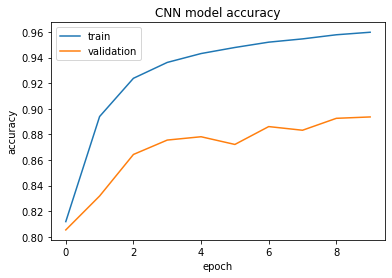

In [22]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

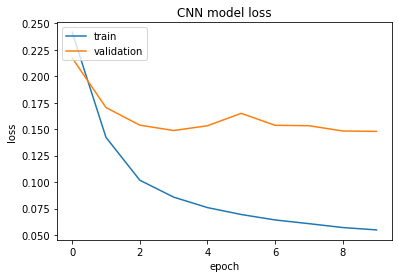

In [23]:
# summarize history for loss
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Model saving

In [23]:
import os
os.remove("C:\\Users\\mrall\\Desktop\\Thesis\\Experiments\\Models\\Model1.h5")
model.save('C:\\Users\\mrall\\Desktop\\Thesis\\Experiments\\Models\\Model1.h5')

# Model loading

In [24]:
from tensorflow.keras.models import load_model
new_model = load_model('C:\\Users\\mrall\\Desktop\\Thesis\\Experiments\\Models\\Model1.h5')